# Задача - классификация людей сердечной недостаточностью. 

Данные содержат 11 признаков:
 0)   Age             918 non-null    int64  - возраст пациента (лет)
 1)   Sex             918 non-null    object - пол пациента (M: мужчина, F: женщина)
 2)   ChestPainType   918 non-null    object - Тип боли в груди (TA: Типичная стенокардия, ATA: Атипичная стенокардия, NAP: Неангинальная боль, ASY: Бессимптомное течение)
 3)   RestingBP       918 non-null    int64  - артериальное давление в покое (мм рт.ст. mm Hg)
 4)   Cholesterol     918 non-null    int64  - холестерин сыворотки крови (мм/дл)
 5)   FastingBS       918 non-null    int64  - уровень сахара в крови натощак (1: если FastingBS > 120 мг/дл, 0: в противном случае)
 6)   RestingECG      918 non-null    object - результаты электрокардиограммы в покое (Normal: нормальная, ST: аномалия ST-T (инверсия зубца T и/или подъем или депрессия ST > 0,05 мВ), LVH: вероятная или определенная гипертрофия левого желудочка по критериям Эстеса)
 7)   MaxHR           918 non-null    int64  - максимальная частота сердечных сокращений (Числовое значение от 60 до 202)
 8)   ExerciseAngina  918 non-null    object - стенокардия, вызванная физической нагрузкой (Y: Да, N: Нет)
 9)   Oldpeak         918 non-null    float64 - oldpeak = ST (Числовое значение, измеренное в депрессии)
 10)  ST_Slope        918 non-null    object - наклон пикового сегмента ST в режиме физической нагрузки (Up: восходящий, Flat: плоский, Down: нисходящий)
 11)  HeartDisease    918 non-null    int64  - выходной класс (1: болезнь сердца, 0: нет болезни)

# Загрузка библиотек:

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score

Несколько вспомогательных функций:
1) encoder_data_processing - преобразование тестовых признаков (Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope) в бинарные признаки
2) missed_data_processing - обнаружение нулевых данных и обработка их. Функция предусматривает 2 варианта: удаление данных или замена на медианное значение
3) abnormal_data_processing - обнаружение выбросов

In [2]:
# convert categorial features to binary features
def encoder_data_processing(idata):
    heart_dat = idata.copy()
        # convert ExerciseAngina and Sex from categories to numbers.    
    enc = OneHotEncoder(drop='if_binary', sparse=False)
    enc.fit(heart_dat[['Sex', 'ExerciseAngina']])
    dummies = pd.DataFrame(enc.transform(heart_dat[['Sex', 'ExerciseAngina']]), 
                           columns=enc.get_feature_names_out(), index=heart_dat.index)
    heart_dat['Sex'] = dummies[dummies.keys()[0]]
    heart_dat['ExerciseAngina'] = dummies[dummies.keys()[1]]
    
        # convert ChestPainType from categories to numbers.
    enc.fit(heart_dat[['ChestPainType']])
    dummies = pd.DataFrame(enc.transform(heart_dat[['ChestPainType']]), 
                           columns=enc.get_feature_names_out(), index=heart_dat.index)
    heart_dat = heart_dat.drop(['ChestPainType'], axis = 1)
    heart_dat[dummies.keys()]  = dummies
    
        # convert RestingECG from categories to numbers. (ST and LVH are abnormal)
    enc.fit(heart_dat[['RestingECG']])
    dummies = pd.DataFrame(enc.transform(heart_dat[['RestingECG']]), 
                           columns=enc.get_feature_names_out(), index=heart_dat.index)
    heart_dat = heart_dat.drop(['RestingECG'], axis = 1)
    heart_dat[dummies.keys()]  = dummies  
    
        # convert ST_Slope from categories to numbers.
    enc.fit(heart_dat[['ST_Slope']])
    dummies = pd.DataFrame(enc.transform(heart_dat[['ST_Slope']]), 
                           columns=enc.get_feature_names_out(), index=heart_dat.index)
    heart_dat = heart_dat.drop(['ST_Slope'], axis = 1)
    heart_dat[dummies.keys()]  = dummies
    return heart_dat

In [3]:
# fuction zero data processing (0 - delete rows; 1 - zero rows to median values)
def missed_data_processing(data, key, zero_data_flag):
    processed_data = data.copy()
    tmp_arr = np.array(processed_data[key])
    zero_id = np.where(tmp_arr == 0)[0]
    nonzero_id = np.where(tmp_arr > 0)[0]
    if zero_data_flag == 0: # zero data -> delete
        processed_data = processed_data.drop(zero_id)
    else:    # zero data -> preprocess
        median_key = processed_data[key][nonzero_id].median()
        processed_data.loc[zero_id][key] = median_key
    return processed_data

In [4]:
# function abnormal row processing (like pulse, very high departure from mean value)
def abnormal_data_processing(data, key, method_flag):
    processed_data = data.copy()
    if method_flag == 0:
        processed_data = processed_data[
            (processed_data[key] >= processed_data[key].quantile(0.005)) & (processed_data[key] <= processed_data[key].quantile(0.995))]
    else:
        Q1, Q3 = processed_data[key].quantile([.25, .75])
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        rows_to_drop = processed_data[
            (processed_data[key] < lower) | (processed_data[key] > upper)].index
        processed_data = processed_data.drop(rows_to_drop)

    return processed_data

# Чтение файла с данными

In [5]:
idata = pd.read_csv('heart.csv')

# Предобработка данных

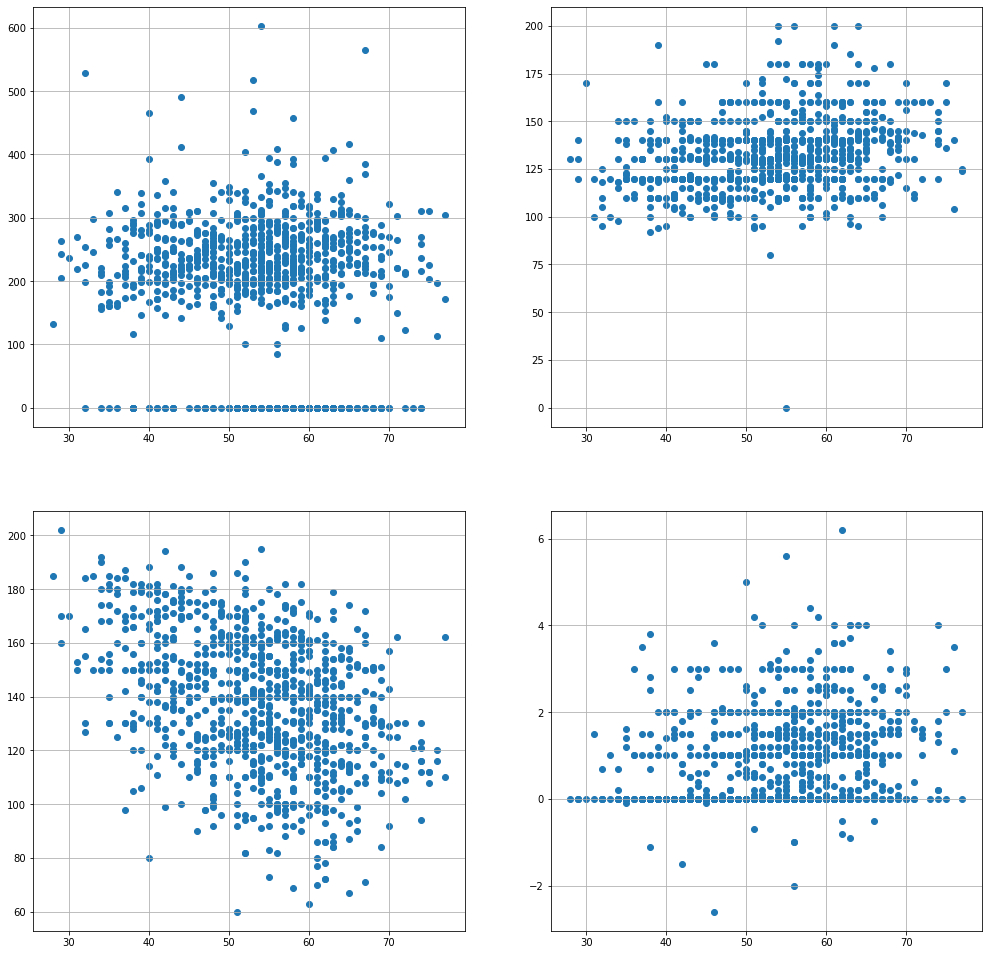

In [6]:
heart_dat = encoder_data_processing(idata)

    # scatter diagramms before preprocessing
plt.figure(1, figsize=(17,17))
plt.subplot(2,2,1)
plt.scatter(heart_dat['Age'], heart_dat['Cholesterol'])
plt.grid()
plt.subplot(2,2,2)
plt.scatter(heart_dat['Age'], heart_dat['RestingBP'])
plt.grid()
plt.subplot(2,2,3)
plt.scatter(heart_dat['Age'], heart_dat['MaxHR'])
plt.grid()
plt.subplot(2,2,4)
plt.scatter(heart_dat['Age'], heart_dat['Oldpeak'])
plt.grid()

В данных часть строк с признаками Cholesterol, RestingBP и MaxHR содержат нулевые значения. Необходимо их обработать.

In [7]:
    # zero data processing (0 - delete rows; 1 - zero rows to median values)
preprocessed_heart_dat = missed_data_processing(heart_dat, 'Cholesterol', 1)
preprocessed_heart_dat = missed_data_processing(preprocessed_heart_dat, 'RestingBP', 1)
preprocessed_heart_dat = missed_data_processing(preprocessed_heart_dat, 'MaxHR', 1)

    # abnormal data processing
preprocessed_heart_dat = abnormal_data_processing(preprocessed_heart_dat, 'Cholesterol', 1)
preprocessed_heart_dat = abnormal_data_processing(preprocessed_heart_dat, 'RestingBP', 1)
preprocessed_heart_dat = abnormal_data_processing(preprocessed_heart_dat, 'MaxHR', 1)


Диаграммы после предобработки данных:

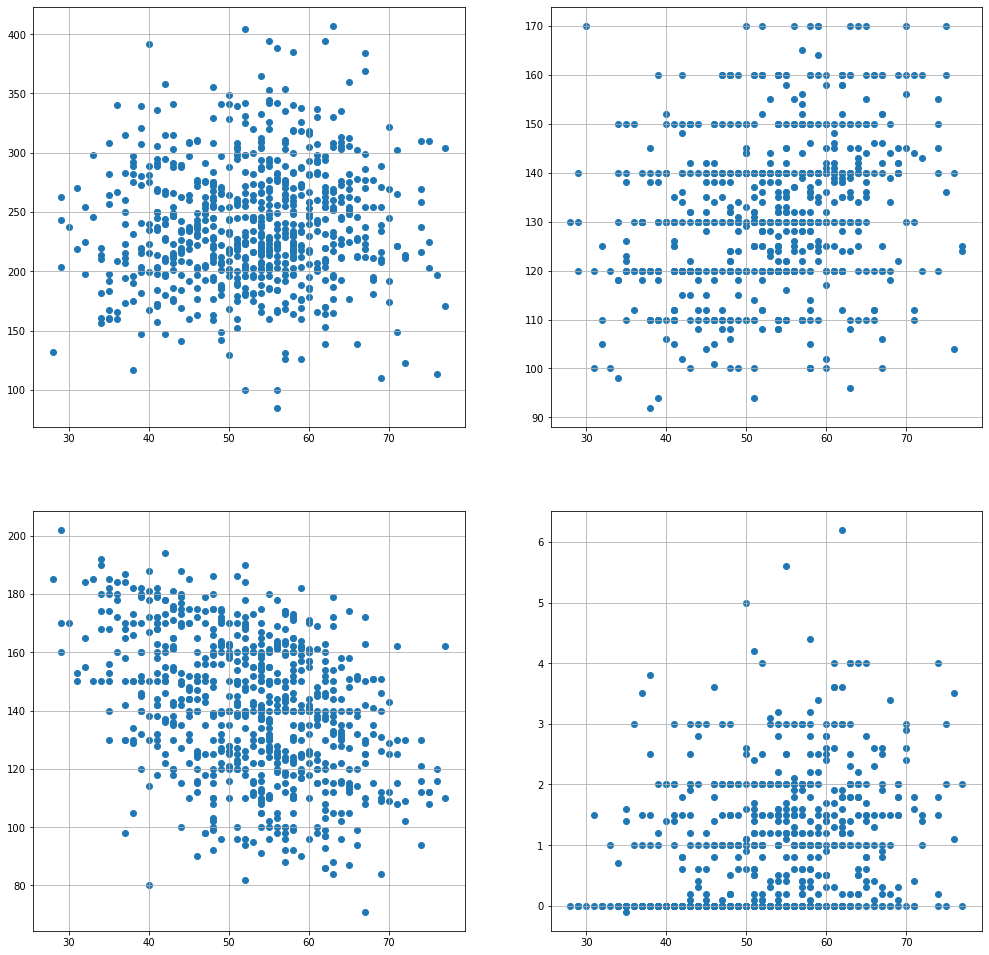

In [8]:
    # scatter diagramms after preprocessing
plt.figure(2, figsize=(17,17))
plt.subplot(2,2,1)
plt.scatter(preprocessed_heart_dat['Age'], preprocessed_heart_dat['Cholesterol'])
plt.grid()
plt.subplot(2,2,2)
plt.scatter(preprocessed_heart_dat['Age'], preprocessed_heart_dat['RestingBP'])
plt.grid()
plt.subplot(2,2,3)
plt.scatter(preprocessed_heart_dat['Age'], preprocessed_heart_dat['MaxHR'])
plt.grid()
plt.subplot(2,2,4)
plt.scatter(preprocessed_heart_dat['Age'], preprocessed_heart_dat['Oldpeak'])
plt.grid()

Из графиков разброса признаков видно, что признаки смещены в область людей с возрастом выше 50 лет.  

<Figure size 1224x1224 with 0 Axes>

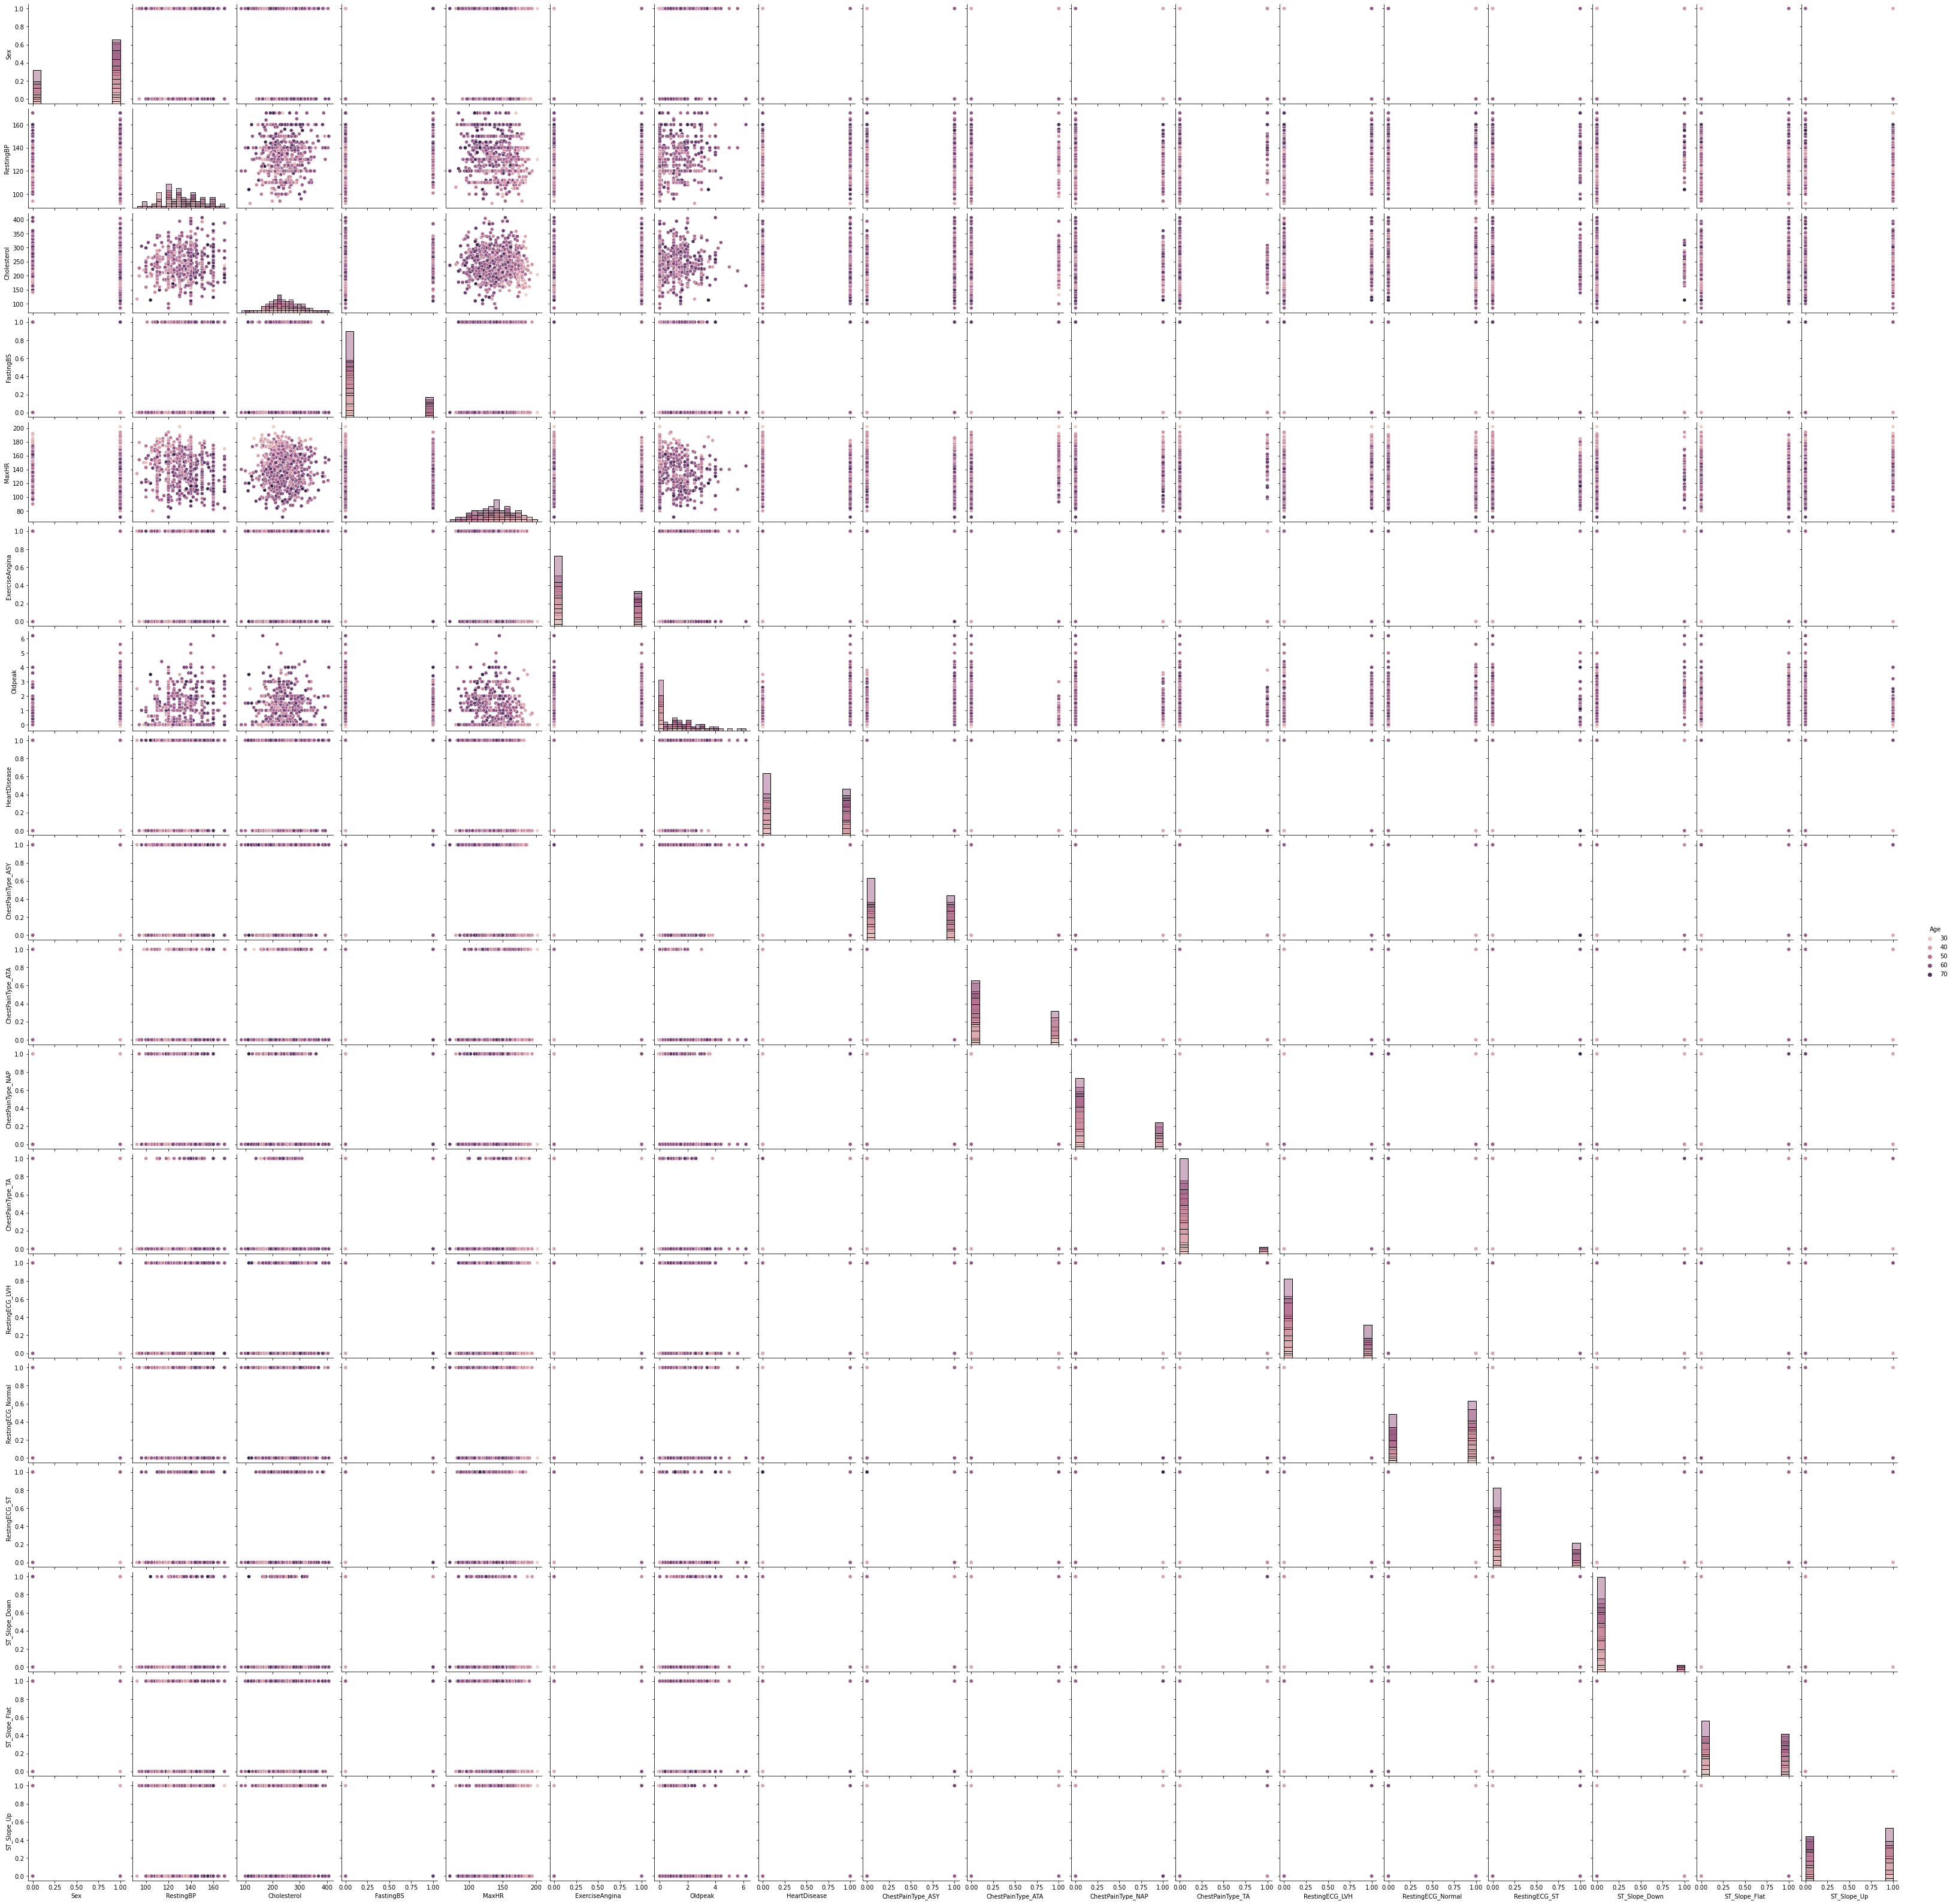

In [9]:
# scatter diagramm for all features
plt.figure(3, figsize=(17,17))
sns.pairplot(preprocessed_heart_dat, hue='Age', diag_kind='hist')

Text(0.5, 1.0, 'corr matrix')

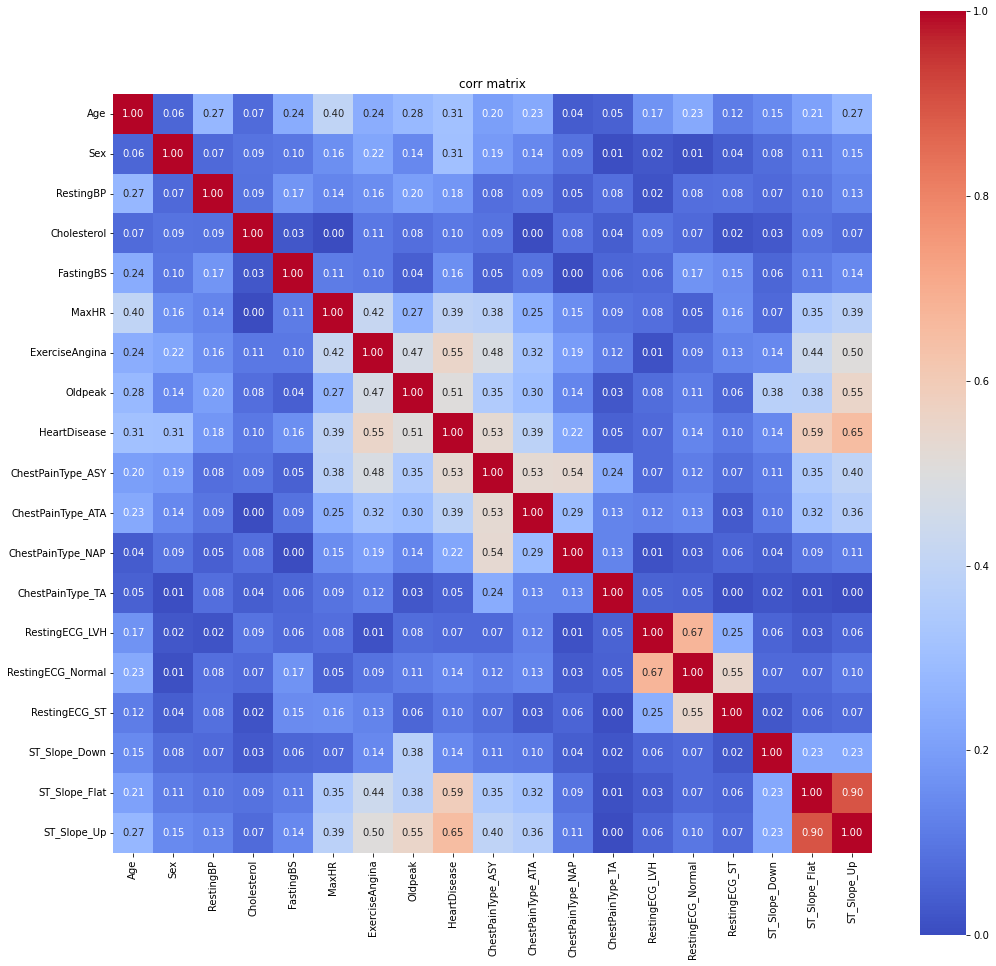

In [10]:
    # correlation matrix
plt.figure(4, figsize=(17,17))
corr_mat = preprocessed_heart_dat.corr()
sns.heatmap(abs(corr_mat), square=True, annot=True, fmt='.2f', vmin=0, vmax=1, cmap='coolwarm')
plt.title('corr matrix')

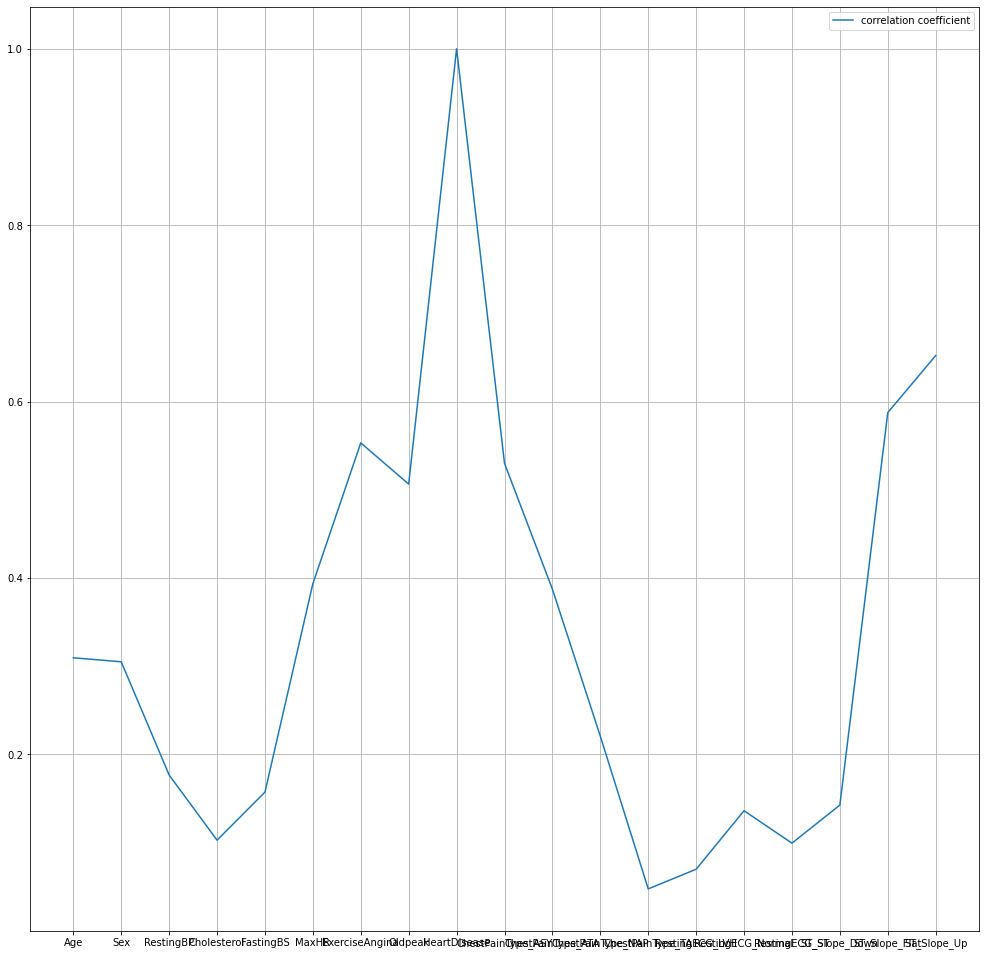

In [11]:
# correlation coeffisient between HeartDisease and features
plt.figure(5, figsize=(17,17))
plt.plot(abs(corr_mat['HeartDisease']))
plt.grid()
plt.legend(['correlation coefficient'])
ids = corr_mat['HeartDisease'][abs(corr_mat['HeartDisease']) < 0.1]

Из коэффициента линейной корреляции видно, что существует сильная зависимость между выходными классами и признаками ST_Slope (Flat, Up), ExerciseAngina, Oldpeak и ChestPainType (ASY) 

# Классификация

Разделим выборку на обучающую (70%) и тестовую выборки (30%). 
Также выполним нормализацию набора данных по каждому признаку в диапазон (0, 1).

In [12]:
dataX = preprocessed_heart_dat.loc[:, preprocessed_heart_dat.columns != 'HeartDisease']
dataY = preprocessed_heart_dat['HeartDisease']
train_ratio = 0.7
test_ratio = 0.3
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size = test_ratio)

print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))


0.482
0.4511627906976744


В тестовой и обучающей выборках получилось приблизительно одинаковое соотношение классов людей с болезнью сердца и здоровых.
При этом классы практически сбалансированы.
Для классификации были выбраны 4 метода: kNN, дерево решений, случайный лес и бэггинг.

In [13]:
# KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(x_train, y_train)
knc_y_predict = knc.predict(x_test)
print('KNeighborsClassifier: ', accuracy_score(knc_y_predict, y_test))

# DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth = 8, criterion = 'gini', max_features = 'sqrt', random_state=0)
dtc.fit(x_train, y_train, sample_weight=None, check_input=True)
dtc_y_predict = dtc.predict(x_test, check_input=True)
print('DecisionTreeClassifier: ', accuracy_score(dtc_y_predict, y_test))

# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 50, max_depth = 10, max_features = 'sqrt', criterion = 'gini', random_state=0)
rfc.fit(x_train, y_train)
rfc_y_predict = rfc.predict(x_test)
print('RandomForestClassifier: ', accuracy_score(rfc_y_predict, y_test))

# BaggingClassifier
bc = BaggingClassifier(base_estimator=SVC(), n_estimators=50, random_state=0)
bc.fit(x_train, y_train)
bc_y_predict = bc.predict(x_test)
print('BaggingClassifier: ', accuracy_score(bc_y_predict, y_test))

KNeighborsClassifier:  0.6604651162790698
DecisionTreeClassifier:  0.8325581395348837
RandomForestClassifier:  0.8697674418604651
BaggingClassifier:  0.7023255813953488


Дерево решений и случайный лес дают наибольшую точность предсказания. Так же они позволяют оценить значимость признаков.

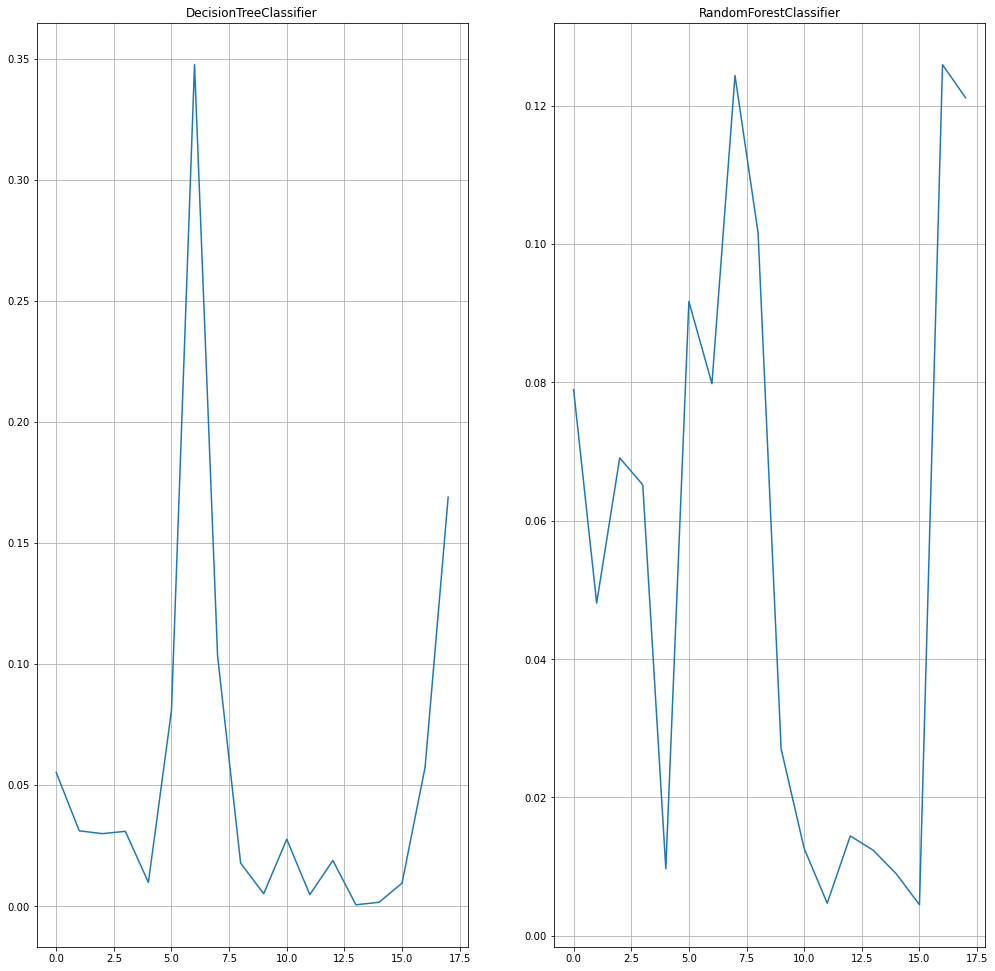

In [14]:
plt.figure(6, figsize=(17,17))
plt.subplot(1,2,1)
plt.plot(dtc.feature_importances_)
plt.title('DecisionTreeClassifier')
plt.grid()
plt.subplot(1,2,2)
plt.plot(rfc.feature_importances_)
plt.title('RandomForestClassifier')
plt.grid()

Из графиков значимости признаков для алгоритма классификации видно, что признаки ExerciseAngina и ST_Slope имеют наибольшее влияние на результат классификации. При этом признаки RestingECG, FastingBS и ChestPainType имеет очень слабое влияние на результат классификации.

# Исследование влияния различных параметров на качество классификации

Text(0, 0.5, 'accuracy')

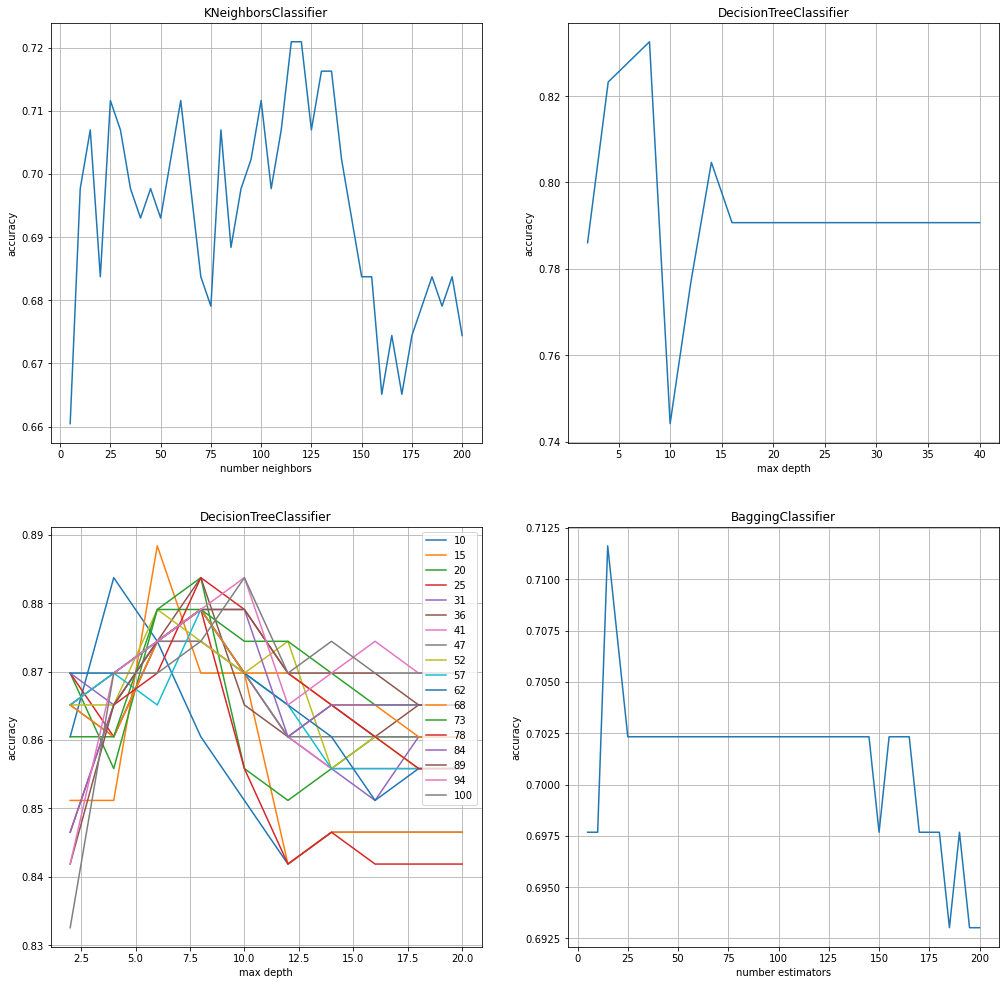

In [15]:
# classification different parameters
# KNeighborsClassifier
n_neighbors_arr = np.linspace(5, 200, 40, dtype = int)
knc_accuracy = np.zeros(40)
for i in range(len(n_neighbors_arr)):
    knc = KNeighborsClassifier(n_neighbors=n_neighbors_arr[i])
    knc.fit(x_train, y_train)
    knc_y_predict = knc.predict(x_test)
    knc_accuracy[i] = accuracy_score(knc_y_predict, y_test)

# DecisionTreeClassifier
max_depth_dt_arr = np.linspace(2, 40, 20, dtype = int)
dtc_accuracy = np.zeros(20)
for i in range(len(max_depth_dt_arr)):
    dtc = DecisionTreeClassifier(max_depth = max_depth_dt_arr[i], criterion = 'gini', max_features = 'sqrt', random_state=0)
    dtc.fit(x_train, y_train, sample_weight=None, check_input=True)
    dtc_y_predict = dtc.predict(x_test, check_input=True)
    dtc_accuracy[i] = accuracy_score(dtc_y_predict, y_test)
    


# RandomForestClassifier
n_estimators_rfc_arr = np.linspace(10, 100, 18, dtype = int)
max_depth_rf_arr = np.linspace(2, 20, 10, dtype = int)
rfc_accuracy = np.zeros([18, 10])
for i in range(len(n_estimators_rfc_arr)):
    for j in range(len(max_depth_rf_arr)):
        rfc = RandomForestClassifier(n_estimators = n_estimators_rfc_arr[i], max_depth = max_depth_rf_arr[j], max_features = 'sqrt', criterion = 'gini', random_state=0)
        rfc.fit(x_train, y_train)
        rfc_y_predict = rfc.predict(x_test)
        rfc_accuracy[i][j] = accuracy_score(rfc_y_predict, y_test)


# BaggingClassifier
n_estimators_bc_arr = np.linspace(5, 200, 40, dtype = int)
bc_accuracy = np.zeros(40)
for i in range(len(n_estimators_bc_arr)):
    bc = BaggingClassifier(base_estimator=SVC(), n_estimators=n_estimators_bc_arr[i], random_state=0)
    bc.fit(x_train, y_train)
    bc_y_predict = bc.predict(x_test)
    bc_accuracy[i] = accuracy_score(bc_y_predict, y_test)
  
    
plt.figure(7, figsize=(17,17))
plt.subplot(2,2,1)
plt.plot(n_neighbors_arr, knc_accuracy)
plt.title('KNeighborsClassifier')
plt.grid()
plt.xlabel('number neighbors')
plt.ylabel('accuracy')

plt.subplot(2,2,2)
plt.plot(max_depth_dt_arr, dtc_accuracy)
plt.title('DecisionTreeClassifier')
plt.grid()
plt.xlabel('max depth')
plt.ylabel('accuracy')

for i in range(len(n_estimators_rfc_arr)):
    plt.subplot(2,2,3)
    plt.plot(max_depth_rf_arr, rfc_accuracy[i][0:])
    plt.title('DecisionTreeClassifier')
    plt.grid()
    plt.xlabel('max depth')
    plt.ylabel('accuracy')
plt.legend(n_estimators_rfc_arr)
plt.grid()


plt.subplot(2,2,4)
plt.plot(n_estimators_bc_arr, bc_accuracy)
plt.title('BaggingClassifier')
plt.grid()
plt.xlabel('number estimators')
plt.ylabel('accuracy')

Наилучший результат это весьма сложный выбор между параметрами алгоритма (от них зависит вычислительная сложность) и точностью

RandomForestClassifier:  0.8697674418604651


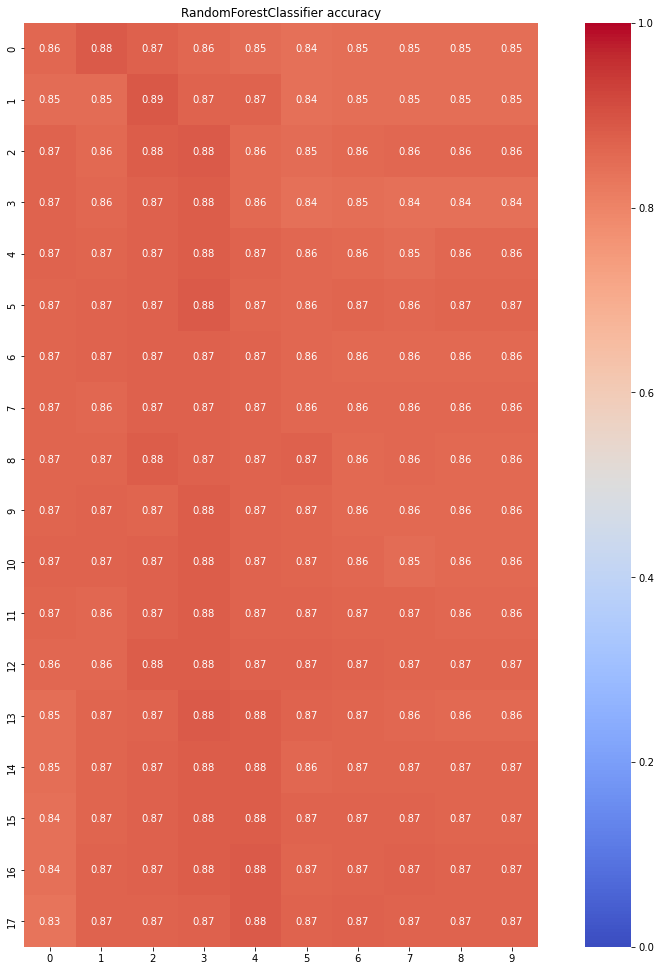

In [16]:
# Best result
plt.figure(8, figsize=(17,17))
sns.heatmap(rfc_accuracy, square=True, annot=True, fmt='.2f', vmin=0, vmax=1, cmap='coolwarm')
plt.title('RandomForestClassifier accuracy')
rfc_accuracy

# Random forest was selected because:
# 1) best accuracy
# 2) lower retraining propability 
# 3) variable "feature_importances_" can be used for drop not important features

rfc = RandomForestClassifier(n_estimators = n_estimators_rfc_arr[2], max_depth = max_depth_rf_arr[0], max_features = 'sqrt', criterion = 'gini', random_state=0)
rfc.fit(x_train, y_train)
rfc_y_predict = rfc.predict(x_test)
print('RandomForestClassifier: ', accuracy_score(rfc_y_predict, y_test))

# Выводы:

1) датасет небольшой, поэтому точность на тестовой выборке сильно зависит от запуска к запуску (то есть зависит от разделения на тестовую и обучающую выборки) 
2) способ борьбы с выбросами и пропущенными значениями сильно влияет на точность (до 5% в зависимости от методов) 
3) график точности для метода "к-ближайших соседей" выглядит как в теоретический: при малом числе соседей точность на тестовой выборке меньше чем на обучающей (недообучение), при увеличении числа соседей достигается максимум, а затем точность на тестовой выборке снижиется (переобучение) 
4) график точности для метода "дерево решений" так же выглядит как теоретический: при небольшой глубине дерева - недообучение, при высокой глубине - переобучение 
5) случайный лес дал наилучшую точность из всех рассмотренных методов и судя по графикам он не переобучивается при увеличении значений гиперпараметров (числа деревьев и их глубины) 
6) для случайного леса должен быть выбран компромис между глубиной деревьев, их числом и точностью. Иногда проще пожертвовать 1-2% в угоду упрощения.